Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [4]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from google.colab import files
import zipfile

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [6]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path('/content/gdrive/My Drive/CNN_assignment/Train')
data_dir_test = pathlib.Path('/content/gdrive/My Drive/CNN_assignment/Test')

In [7]:
if not data_dir_train.exists():
    print(f"Training directory {data_dir_train} does not exist.")
if not data_dir_test.exists():
    print(f"Test directory {data_dir_test} does not exist.")

image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

seed = 123

# Path to your dataset directory
data_dir = '/content/gdrive/My Drive/CNN_assignment'

Use 80% of the images for training, and 20% for validation.

In [9]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,                # Path to the training data
  seed=seed,                     # Random seed for reproducibility
  validation_split=0.2,          # 80% training, 20% validation
  subset='training',             # Use the 'training' subset of the dataset
  image_size=(img_height, img_width),  # Resize images to img_height * img_width
  batch_size=batch_size          # Number of images per batch
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,                # Path to the training data
  seed=seed,                     # Random seed for reproducibility
  validation_split=0.2,          # 80% training, 20% validation
  subset='validation',           # Use the 'validation' subset of the dataset
  image_size=(img_height, img_width),  # Resize images to img_height * img_width
  batch_size=batch_size          # Number of images per batch
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

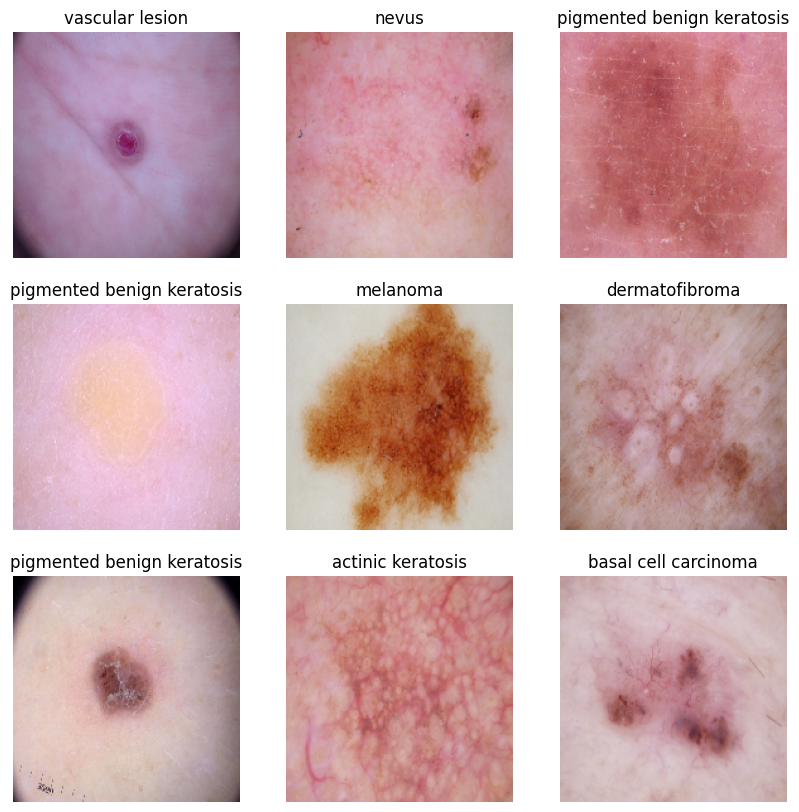

In [12]:
import matplotlib.pyplot as plt

# Extract one batch of images and labels
image_batch, label_batch = next(iter(train_ds))

# Get class names from the dataset
class_names = train_ds.class_names

len_cn_train_ds = len(train_ds.class_names)

# Plot one image from each class
plt.figure(figsize=(10, 10))
for i in range(len_cn_train_ds):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))  # Convert tensor to numpy array
    plt.title(class_names[label_batch[i]])  # Use the label directly as an index
    plt.axis("off")
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [19]:
#NOTE: The layers.experimental.preprocessing.Rescaling API has been updated in TensorFlow 2.x

# Model architecture
model = models.Sequential([
    # Rescale pixel values to [0, 1]
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),  # Normalize input

    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Fourth convolutional block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flatten and fully connected layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),  # Fully connected layer with 512 neurons

    # Output layer for 9 classes
    layers.Dense(9, activation='softmax')  # 9 output classes with softmax activation for multiclass classification
])


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [20]:
# Compile the model with appropriate optimizer and loss function
model.compile(optimizer='adam',  # Adam optimizer
              loss='sparse_categorical_crossentropy',  # Loss for multiclass classification with integer labels
              metrics=['accuracy'])  # Accuracy as the evaluation metric



In [21]:
# View the summary of all layers
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │       5,308,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,554,377 (21.19 MB)

 Trainable params: 5,554,377 (21.19 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [22]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.2188 - loss: 2.1255 - val_accuracy: 0.3848 - val_loss: 1.7461
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.3820 - loss: 1.7267 - val_accuracy: 0.4407 - val_loss: 1.5559
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4566 - loss: 1.5149 - val_accuracy: 0.4183 - val_loss: 1.6082
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4668 - loss: 1.5411 - val_accuracy: 0.4989 - val_loss: 1.5054
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5033 - loss: 1.3990 - val_accuracy: 0.5213 - val_loss: 1.3983
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5263 - loss: 1.3637 - val_accuracy: 0.5190 - val_loss: 1.4455
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5255 - loss: 1.3517 - val_accuracy: 0.5123 - val_loss: 1.3860
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5277 - loss: 1.2793 - val_accuracy: 0.5145 - v

### Visualizing training results

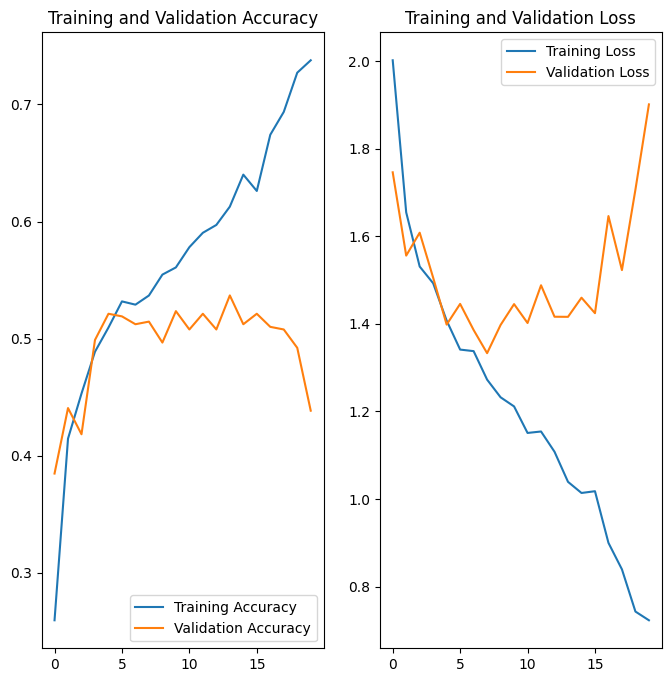

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here
Initial Accuracy & Loss Trends:

The training started with an accuracy of 21.88% and a loss of 2.1255, while validation accuracy was 38.48% and loss 1.7461.
Over the initial epochs, the model showed a consistent improvement in both training and validation accuracy, reaching above 50% accuracy by the 6th epoch for both training and validation.

Validation Performance:

While the training accuracy improved steadily (reaching 75.97% by epoch 20), validation accuracy peaked at around 53.69% by epoch 14 and then began to drop.
The validation loss fluctuated, eventually increasing to 1.9012 by the 20th epoch, indicating a potential overfitting of the model.

Overfitting Signs:

The model's training accuracy continued to increase significantly, but the validation accuracy plateaued and started to drop in later epochs.
The validation loss increased after epoch 8, further indicating that the model is learning to fit the training data too closely and is failing to generalize well to unseen data.

Key Epochs:

Epoch 14 seems to be a turning point, where the training accuracy continued improving, but the validation accuracy stopped improving, and the loss began to rise.
Beyond Epoch 14, the model clearly starts overfitting as validation performance deteriorates while training accuracy continues to improve.

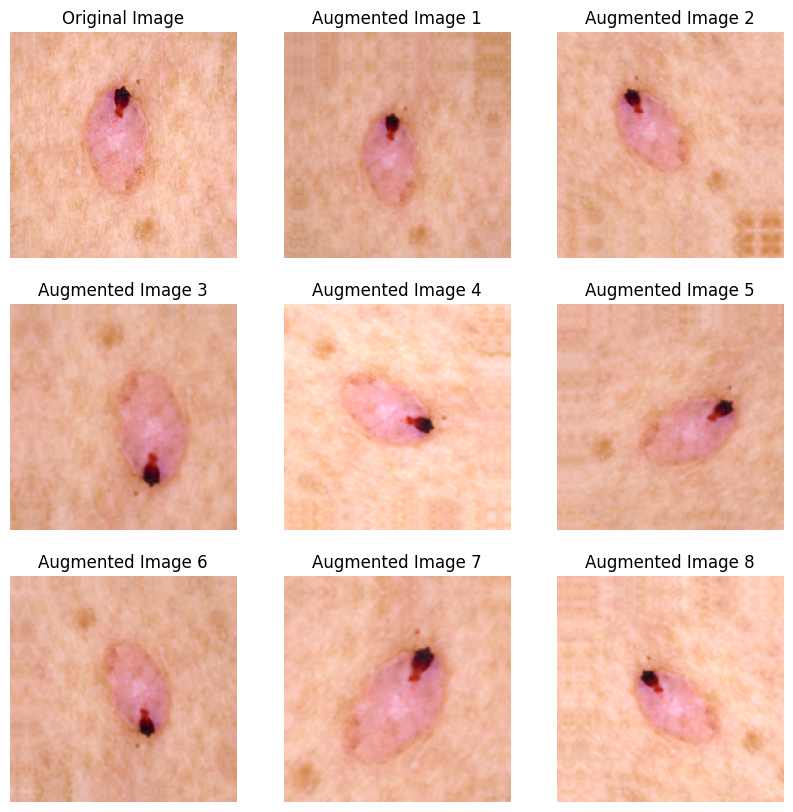

In [24]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here

from tensorflow.keras import layers

# Data Augmentation Strategy
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),  # Randomly flip images horizontally and vertically
    layers.RandomRotation(0.2),  # Randomly rotate images by 20%
    layers.RandomZoom(0.2),  # Random zoom in and out by 20%
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Randomly translate images
    layers.RandomContrast(0.1),  # Randomly adjust contrast
    layers.RandomBrightness(0.1),  # Randomly adjust brightness
])

# Visualizing some examples of the augmented images
for images, _ in train_ds.take(1):
    sample_image = images[0].numpy().astype("uint8")

    # Plot the original image
    plt.figure(figsize=(10, 10))
    plt.subplot(3, 3, 1)
    plt.imshow(sample_image)
    plt.title("Original Image")
    plt.axis("off")

    # Apply data augmentation several times and plot the augmented images
    for i in range(8):
        augmented_image = data_augmentation(tf.expand_dims(sample_image, axis=0))
        plt.subplot(3, 3, i + 2)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.title(f"Augmented Image {i+1}")
        plt.axis("off")

    plt.show()



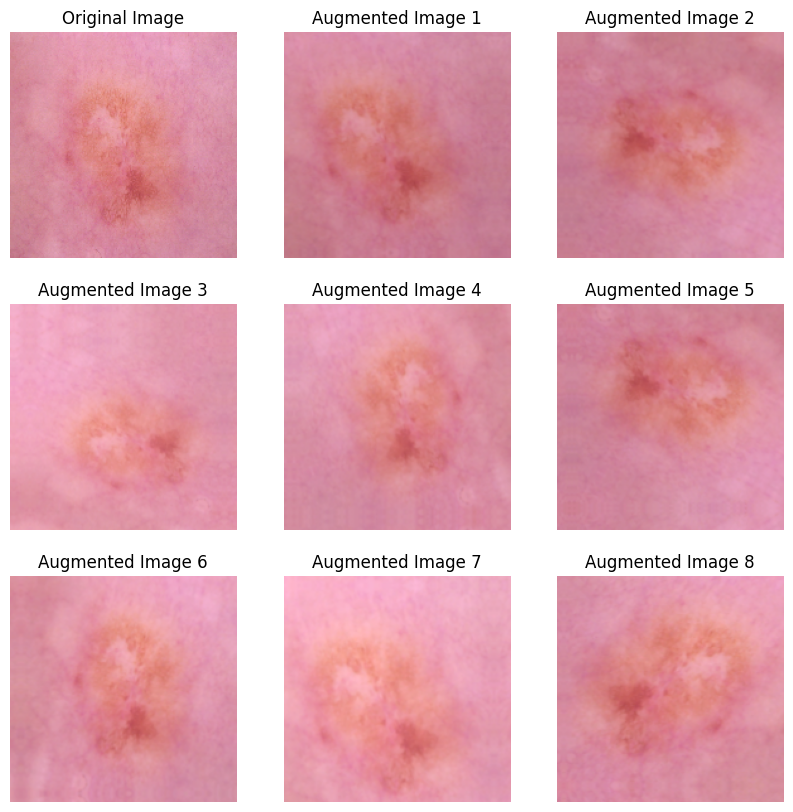

In [25]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

# Take one batch of images from the training dataset
for images, _ in train_ds.take(1):
    # Select one image from the batch
    sample_image = images[0].numpy().astype("uint8")

    # Plot the original image
    plt.figure(figsize=(10, 10))
    plt.subplot(3, 3, 1)
    plt.imshow(sample_image)
    plt.title("Original Image")
    plt.axis("off")

    # Apply data augmentation several times and plot the augmented images
    for i in range(8):
        augmented_image = data_augmentation(tf.expand_dims(sample_image, axis=0))
        plt.subplot(3, 3, i + 2)
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.title(f"Augmented Image {i+1}")
        plt.axis("off")

    plt.show()


### Todo:
### Create the model, compile and train the model


In [26]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here


from tensorflow.keras import layers, models

# Define the model architecture
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  # Normalize pixel values to [0,1]

    # First Convolutional Block
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Third Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    # Flatten the output and add Dense layers
    layers.Flatten(),

    # Fully Connected Layers
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),  # Dropout to reduce overfitting

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),  # Dropout to reduce overfitting

    # Output Layer
    layers.Dense(len_cn_train_ds, activation='softmax')  # Use num_classes for your number of categories
])

# Summary of the model
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 89, 89, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 43, 43, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 20, 20, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │      13,107,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,235,657 (50.49 MB)

 Trainable params: 13,235,209 (50.49 MB)

 Non-trainable params: 448 (1.75 KB)

### Compiling the model

In [27]:
## Your code goes here
# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy if labels are integers
    metrics=['accuracy']
)



### Training the model

In [28]:
## Your code goes here, note: train your model for 20 epochs
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.1725 - loss: 7.5002 - val_accuracy: 0.2349 - val_loss: 10.9030
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.2833 - loss: 11.1784 - val_accuracy: 0.1499 - val_loss: 13.6731
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2871 - loss: 11.2908 - val_accuracy: 0.1767 - val_loss: 13.2079
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3700 - loss: 10.0463 - val_accuracy: 0.2058 - val_loss: 12.8007
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3237 - loss: 10.8626 - val_accuracy: 0.2081 - val_loss: 12.7647
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3292 - loss: 10.7960 - val_accuracy: 0.2282 - val_loss: 12.4229
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3319 - loss: 10.7373 - val_accuracy: 0.3199 - val_loss: 10.9492
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3202 - loss: 10.9264 - val_accur

### Visualizing the results

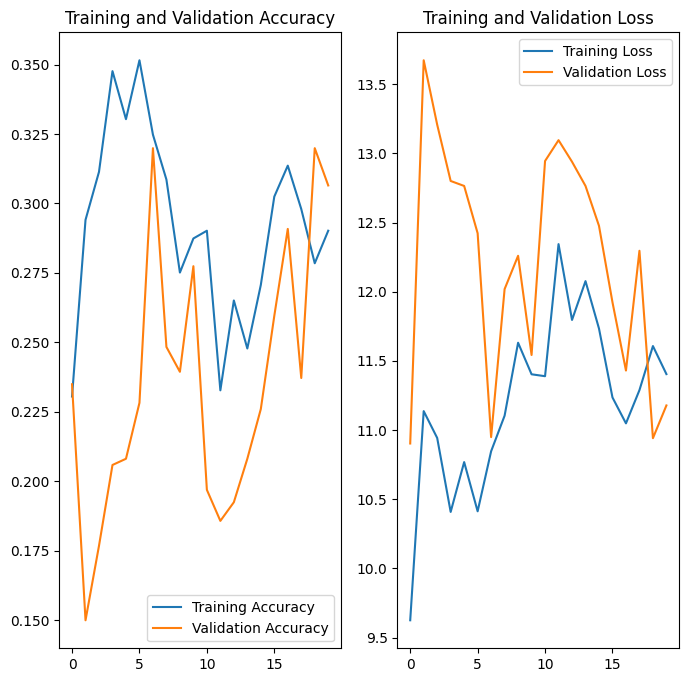

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

Initial Performance:

The model starts with an accuracy of 17.25% and a high loss of 7.5002 in the first epoch. The validation accuracy is 23.49% with an even higher validation loss of 10.9030.
This suggests that the model is struggling to learn useful features early on, possibly due to the complexity of the data or the overly strong regularization from the dropout layer.

Training Accuracy Stagnation:

The training accuracy fluctuates around 23-33%, with a peak at 37.00% in epoch 4, and then decreases slightly.
This indicates that the model is not able to learn effectively, potentially due to the dropout rate being too high, which might be forcing the model to "forget" too much during training.

Validation Performance:

The validation accuracy starts around 23% but generally remains below 32% throughout the training.
The validation loss remains high throughout, suggesting that the model is not generalizing well. At the end of the 20 epochs, the validation loss is still high at 11.1781.
Dropout Impact:

The introduction of dropout was intended to prevent overfitting, but in this case, it seems to have hurt the model's ability to learn. This could be due to an overly aggressive dropout rate, causing the network to discard too many neurons during training.
Lack of Improvement:

The model does not show significant improvement in accuracy or loss throughout the 20 epochs, with the final accuracy being 29.02% and the validation accuracy at 30.65%.
Both training and validation losses remain high, indicating that the model is not able to reduce the error effectively.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [30]:
## Your code goes here.
import os
from collections import Counter

# Define the path to the training dataset
data_dir_train = '/content/gdrive/My Drive/CNN_assignment/Train'

# List all subdirectories (i.e., class names) in the training directory
class_names = os.listdir(data_dir_train)

# Dictionary to hold the count of images per class
class_distribution = {}

# Loop through each class directory and count the number of images
for class_name in class_names:
    class_dir = os.path.join(data_dir_train, class_name)
    if os.path.isdir(class_dir):
        # Count the number of images in this class directory
        num_images = len([f for f in os.listdir(class_dir) if f.endswith('.jpg')])
        class_distribution[class_name] = num_images

# Display the distribution of classes
print("Class distribution in training dataset:")
for class_name, count in class_distribution.items():
    print(f"Class: {class_name}, Number of images: {count}")


Class distribution in training dataset:
Class: actinic keratosis, Number of images: 114
Class: dermatofibroma, Number of images: 95
Class: nevus, Number of images: 357
Class: seborrheic keratosis, Number of images: 77
Class: squamous cell carcinoma, Number of images: 181
Class: pigmented benign keratosis, Number of images: 462
Class: melanoma, Number of images: 438
Class: basal cell carcinoma, Number of images: 376
Class: vascular lesion, Number of images: 139


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?

Class with the least number of samples:
The class seborrheic keratosis has the least number of samples, with only 77 images.
Classes dominating the data in terms of proportionate number of samples:
The classes pigmented benign keratosis (462 images), melanoma (438 images), and basal cell carcinoma (376 images) dominate the dataset, having a significantly higher number of samples compared to other classes.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [31]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [32]:
path_to_training_dataset='/content/gdrive/My Drive/CNN_assignment/Train'
import Augmentor
for i in class_names:
    class_path = os.path.join(path_to_training_dataset, i)
    p = Augmentor.Pipeline(class_path)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA32E2BEE60>: 100%|██████████| 500/500 [00:28<00:00, 17.30 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA2994101C0>: 100%|██████████| 500/500 [00:19<00:00, 26.30 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA2A05E6410>: 100%|██████████| 500/500 [01:33<00:00,  5.37 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA2A046CFD0>: 100%|██████████| 500/500 [00:41<00:00, 12.09 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA2A0FC5A20>: 100%|██████████| 500/500 [00:18<00:00, 27.31 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA2A05C03A0>: 100%|██████████| 500/500 [00:18<00:00, 26.52 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA2A0689B40>: 100%|██████████| 500/500 [01:20<00:00,  6.19 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA2A05FF5B0>: 100%|██████████| 500/500 [00:18<00:00, 27.65 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA2ACCC3220>: 100%|██████████| 500/500 [00:21<00:00, 23.10 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [33]:
# Define the path to your training dataset
data_dir_train = '/content/gdrive/My Drive/CNN_assignment/Train'

# Convert data_dir_train to a Path object
data_dir_train_path = pathlib.Path(data_dir_train)

# Get the count of images in the 'output' subdirectories
image_count_train = len(list(data_dir_train_path.glob('*/output/*.jpg')))
print(image_count_train)


4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [34]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/My Drive/CNN_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027802.jpg_d78b6a49-5777-44f9-8b8e-7fef93ef1d4f.jpg',
 '/content/gdrive/My Drive/CNN_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031108.jpg_41ee99cb-7c7a-4aef-837e-ebe7da7c6df0.jpg',
 '/content/gdrive/My Drive/CNN_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027615.jpg_169ebf3f-9086-47a2-a6a9-ac4046c9e408.jpg',
 '/content/gdrive/My Drive/CNN_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030877.jpg_b6fa8182-33a7-44d9-b161-255c25bdffc2.jpg',
 '/content/gdrive/My Drive/CNN_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029930.jpg_cfd47f21-9a2b-49b8-8488-a57dfcd9dc55.jpg',
 '/content/gdrive/My Drive/CNN_assignment/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0025803.jpg_f2bea231-68ad-44b5-b758-2bb56a15b9f6.jpg',
 '/content/gdrive/My Drive/CNN_assignmen

In [39]:
lesion_list = []
for path in path_list:
    lesion_list.append(path.split('/')[-2])

dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()),columns = ['Path','Label'])

In [40]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [41]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [42]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()), columns=['Path', 'Label'])
new_df = pd.concat([original_df, df2], ignore_index=True)
print(new_df)

                                                   Path            Label
0     /content/gdrive/My Drive/CNN_assignment/Train/...           output
1     /content/gdrive/My Drive/CNN_assignment/Train/...           output
2     /content/gdrive/My Drive/CNN_assignment/Train/...           output
3     /content/gdrive/My Drive/CNN_assignment/Train/...           output
4     /content/gdrive/My Drive/CNN_assignment/Train/...           output
...                                                 ...              ...
8995  /content/gdrive/My Drive/CNN_assignment/Train/...  vascular lesion
8996  /content/gdrive/My Drive/CNN_assignment/Train/...  vascular lesion
8997  /content/gdrive/My Drive/CNN_assignment/Train/...  vascular lesion
8998  /content/gdrive/My Drive/CNN_assignment/Train/...  vascular lesion
8999  /content/gdrive/My Drive/CNN_assignment/Train/...  vascular lesion

[9000 rows x 2 columns]


In [43]:
new_df['Label'].value_counts()

,count
Label,
output,4500
actinic keratosis,500
dermatofibroma,500
nevus,500
seborrheic keratosis,500
squamous cell carcinoma,500
pigmented benign keratosis,500
melanoma,500
basal cell carcinoma,500


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [44]:
batch_size = 32
img_height = 180
img_width = 180
seed = 123

#### **Todo:** Create a training dataset

In [45]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)


Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [46]:
# Create the validation dataset (20% of the data)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [47]:
# Prefetch data for faster performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### **Todo:** Create your model (make sure to include normalization)

In [48]:
from tensorflow.keras import layers, models

# Create a CNN model with normalization layers
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  # Normalization layer
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dropout(0.5),  # Use dropout if overfitting is observed

    layers.Dense(512, activation='relu'),
    layers.Dense(9, activation='softmax')  # 9 output classes (change if different)
])

# Print model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 18, 18, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 10368)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 512)                 │       5,308,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,554,377 (21.19 MB)

 Trainable params: 5,554,377 (21.19 MB)

 Non-trainable params: 0 (0.00 B)

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [49]:
# Compile the model with appropriate optimizer and loss function
model.compile(
    optimizer='adam',  # Adam optimizer works well for most problems
    loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for integer labels
    metrics=['accuracy']
)


#### **Todo:**  Train your model

In [50]:
# Train the model
epochs = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 55s 113ms/step - accuracy: 0.2403 - loss: 1.9765 - val_accuracy: 0.3846 - val_loss: 1.6192
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - accuracy: 0.3996 - loss: 1.5518 - val_accuracy: 0.4573 - val_loss: 1.4162
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.4662 - loss: 1.4009 - val_accuracy: 0.5115 - val_loss: 1.2896
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5409 - loss: 1.2464 - val_accuracy: 0.5249 - val_loss: 1.1764
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5657 - loss: 1.1833 - val_accuracy: 0.6214 - val_loss: 1.0081
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6330 - loss: 0.9637 - val_accuracy: 0.6533 - val_loss: 0.9300
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6657 - loss: 0.8732 - val_accuracy: 0.6808 - val_loss: 0.8220
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7334 - loss: 0.7297 - val_a

#### **Todo:**  Visualize the model results

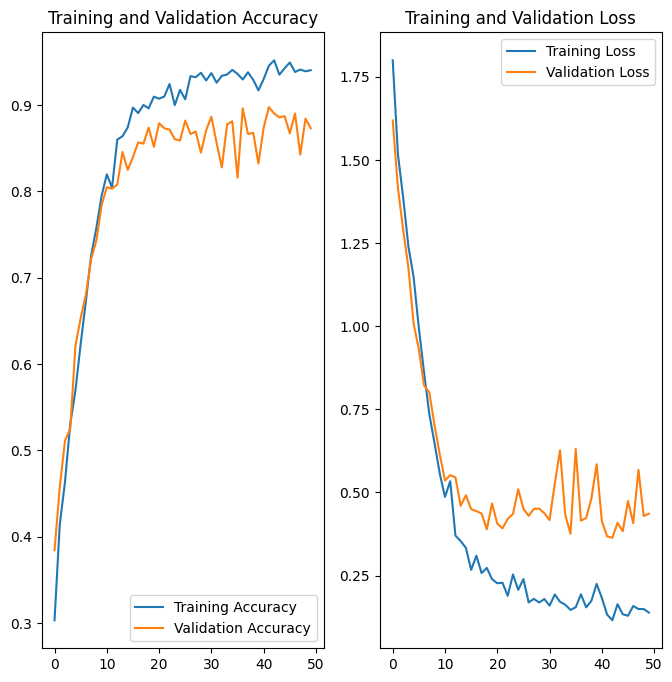

In [52]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

Overfitting/Underfitting:

Initial Training and Validation Progress:

The model's accuracy starts at 24% in epoch 1 and quickly improves to 94.42% by epoch 50.
The validation accuracy begins at 38.46% and gradually increases to around 87.31% by the end.
Both training and validation accuracy improve steadily, indicating that the model is learning effectively, with no signs of underfitting.
Validation Loss and Accuracy:

The validation loss starts at 1.6192 and decreases to 0.4362 by epoch 50.
The gap between training and validation losses is minimal throughout training, with both consistently improving, indicating that overfitting is not a significant issue.
Even though the validation loss fluctuates a bit in the later epochs, it remains relatively close to the training loss, suggesting good generalization.
Class Rebalancing:

The steady increase in validation accuracy, coupled with consistent loss reduction, suggests that class rebalancing was effective. In many cases of imbalanced datasets, models struggle with low validation accuracy or generalization, which does not seem to be the case here.
Class rebalancing likely improved the model's ability to generalize across different categories, reducing bias toward overrepresented classes.
Key Findings:
Overfitting: There is no significant sign of overfitting, as the validation accuracy closely follows the training accuracy and both losses are in sync.
Underfitting: The model starts with low accuracy but rapidly improves, indicating it is not underfitting and is capable of learning effectively from the data.
Class Rebalancing: The class rebalancing appears to have contributed to a balanced performance, as reflected in the smooth increase of validation accuracy and the steady reduction of validation loss.
Conclusion:
The model has effectively mitigated both overfitting and underfitting, and the class rebalancing strategy has positively impacted the training process, allowing the model to generalize well. However, further fine-tuning of the dropout rate or early stopping could be explored to optimize the model’s performance and avoid minor fluctuations in loss.

